<a href="https://colab.research.google.com/github/bgtripp/Computational-Modeling-and-Simulation/blob/master/v2_DCGAN_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Used these sources:
#https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#https://github.com/dvschultz/ai/blob/master/StyleGAN2.ipynb
#https://github.com/pytorch/examples/issues/70
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb
#https://github.com/soumith/dcgan.torch/issues/2#issuecomment-283982237
#https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/
#https://github.com/soumith/ganhacks
#https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4

#Used this dataset:
#https://www.kaggle.com/puneet6060/intel-image-classification#20142.jpg

import time
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

# Set random seem for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1312


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#Root directory for project
rootdir = "/content/drive/My Drive/GAN Projects/DCGAN Forest"

#Saved model directory
modeldir = os.path.join(rootdir, "models")

# Root directory for images
dataroot = os.path.join(rootdir, "forest_images")

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available
ngpu = 1

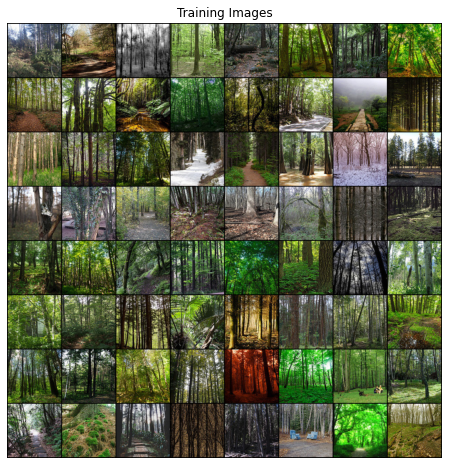

In [0]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [0]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #Adding gaussian noise to input layer to help stabilize learning
            GaussianNoise(),
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): GaussianNoise()
    (1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Batch

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Nicely formatted time string -- Thanks Jeff Heaton
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

print("Starting Training Loop...")

# For each epoch
start = time.time()

last_epoch = start

for epoch in range(num_epochs):
    epoch_start = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            elapsed = time.time()-start
            epoch_elapsed = time.time()-last_epoch
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tEpoch_Length: %s\tElapsed: %s'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, hms_string(epoch_elapsed), hms_string(elapsed)))
            last_epoch = time.time()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Starting Training Loop...
[0/200][0/18]	Loss_D: 2.0006	Loss_G: 5.5316	D(x): 0.4924	D(G(z)): 0.5954 / 0.0066	Epoch_Length: 0:00:01.69	Elapsed: 0:00:01.69
[1/200][0/18]	Loss_D: 4.0070	Loss_G: 13.6771	D(x): 0.3515	D(G(z)): 0.8522 / 0.0000	Epoch_Length: 0:00:10.00	Elapsed: 0:00:11.69
[2/200][0/18]	Loss_D: 2.9450	Loss_G: 7.6864	D(x): 0.2842	D(G(z)): 0.6248 / 0.0008	Epoch_Length: 0:00:09.94	Elapsed: 0:00:21.64
[3/200][0/18]	Loss_D: 2.4987	Loss_G: 1.2734	D(x): 0.3627	D(G(z)): 0.6277 / 0.3335	Epoch_Length: 0:00:09.91	Elapsed: 0:00:31.56
[4/200][0/18]	Loss_D: 1.6646	Loss_G: 1.1816	D(x): 0.3951	D(G(z)): 0.4630 / 0.3282	Epoch_Length: 0:00:09.90	Elapsed: 0:00:41.47
[5/200][0/18]	Loss_D: 1.5978	Loss_G: 1.4174	D(x): 0.5190	D(G(z)): 0.5235 / 0.2934	Epoch_Length: 0:00:09.93	Elapsed: 0:00:51.40
[6/200][0/18]	Loss_D: 1.5631	Loss_G: 0.9153	D(x): 0.5472	D(G(z)): 0.5637 / 0.4259	Epoch_Length: 0:00:09.92	Elapsed: 0:01:01.32
[7/200][0/18]	Loss_D: 1.7104	Loss_G: 1.1212	D(x): 0.5688	D(G(z)): 0.5698 / 0.4269	Ep

In [0]:
#Save model
from datetime import datetime
modelname = f"{manualSeed}_{num_epochs}_{image_size}.pt"
modelpath = os.path.join(modeldir, modelname)
torch.save(netG, modelpath)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


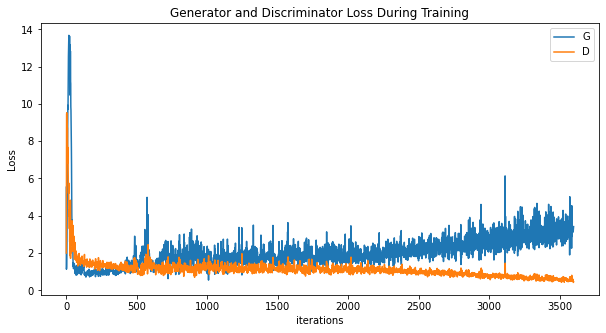

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
#Did this all myself too, woo!

imgdir = os.path.join(rootdir, 'images')
newimgs = os.path.join(imgdir, f'{batch_size}_{num_epochs}_{manualSeed}')

if not os.path.exists(newimgs): os.mkdir(newimgs)

for n, i in enumerate(img_list):
  imstr = "/{}/{}.png".format(newimgs, n)
  imgpath = os.path.join(imgdir, imstr)
  vutils.save_image(i, imgpath)

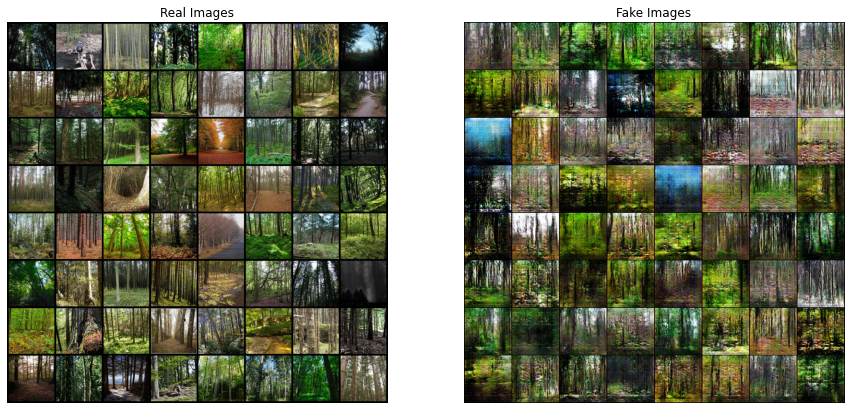

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Test existing model

In [0]:
#Load existing model
#Model class must be defined somewhere
model = torch.load(modelpath)
model.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


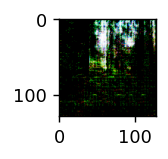

In [0]:
noise = torch.randn(1, nz, 1, 1, device=device)
new_fake = model(noise).cpu().detach()
original = np.transpose(new_fake[-1],(1,2,0))

normalized = vutils.make_grid(original, padding=2, normalize=True)

plt.figure(figsize=(1,1), dpi=128)
plt.imshow(normalized)